# Laminar ROI analysis of power in source space

This tutorial demonstrates how to perform laminar inference using an ROI analysis of power in source space, described in [Bonaiuto et al., 2018, Non-invasive laminar inference with MEG: Comparison of methods and source inversion algorithms](https://doi.org/10.1016/j.neuroimage.2017.11.068), and used in [Bonaiuto et al., 2018, Lamina-specific cortical dynamics in human visual and sensorimotor cortices](https://doi.org/10.7554/eLife.33977). A 20Hz oscillation is simulated at a particular cortical location in various layers. Source reconstruction is performed using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on a multilayer mesh, thus providing an estimate of source activity on each layer. An ROI is defined by comparing power in the 10-30 Hz frequency band during the time period containing the simulated activity with a prior baseline period at each vertex using paired t-tests. Vertices in either surface with a t-statistic above a percentile threshold of the t-statistics over all vertices in that surface, as well as the corresponding vertices in the other surface, are included in the ROI. This ensures that the contrast used to define the ROI was orthogonal to the subsequent laminar contrast. For each trial, ROI values for each layer are computed by averaging the absolute value of the change in power compared to baseline in that surface within the ROI. Finally, a paired t-test is used to compare the ROI values from each layer over trials. All t-tests are done using corrected noise variance estimates in order to attenuate artifactually high significance values [Ridgway et al., 2012](https://doi.org/10.1016/j.neuroimage.2011.10.027).

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from scipy import stats
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.laminar import roi_power_comparison
from lameg.simulate import run_current_density_simulation
from lameg.surf import interpolate_data
from lameg.viz import show_surface, color_map
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas = [0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa = [-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa = [76.02110531729883, 18.9467849625573, -25.779407159603114]

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations and source reconstructions will be based on a forward model using the multilayer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri/s2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf/multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/roi'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
22-Jul-2024 19:25:25 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 19:25:25 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           19:25:25 - 22/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiome

## Simulating a signal on the pial surface
We're going to simulate 1s of signal with a 20Hz sine wave that starts at 0.5s with a dipole moment of 10nAm

Text(0, 0.5, 'Amplitude (nAm)')

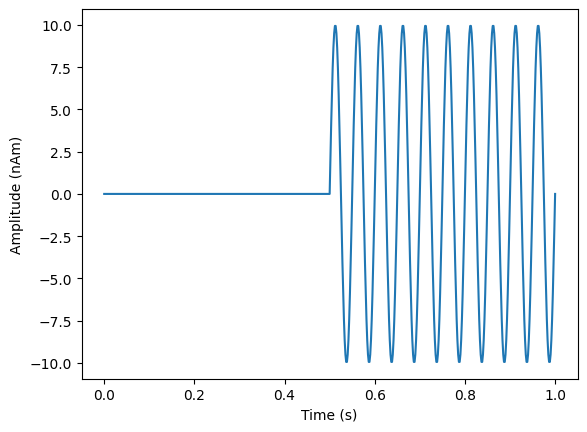

In [5]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 600

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,1,s_rate+1)
sim_signal = np.zeros(time.shape).reshape(1,-1)
t_idx=np.where(time>=0.5)[0]
sim_signal[0,t_idx] = np.sin(time[t_idx]*freq*2*np.pi)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

In [6]:
# Vertex to simulate activity at
sim_vertex=24585

pial_ds_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

Output()

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [7]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -10

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)   

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 655.24 pAm/mm2, peak momemnt density 1216.78 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 655.24, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1216.78, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior777361.mat
Setting white noise to give sensor level SNR of -10B
Assembling 1 prior components
end assemble

 Finish


## Laminar comparison (pial - white matter)
Now we can run source reconstruction using a source model based on the multi-laminar surface, define an ROI based on the change in power from a baseline time period, and then compare the change in power between the pial and white matter surfaces. First we'll run the inversion.

In [8]:
# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    pial_sim_fname,
    spm_instance=spm
)

# Run inversion on simulated data in a 5Hz window around the simulated frequency using the multilayer surface
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    pial_sim_fname, 
    n_layers, 
    foi=[freq-10, freq+10],
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 19:41:10 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 19:41:10 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           19:41:26 - 22/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for 

Now we can defined the ROI based on where the change in power from baseline exceeds some percentile threshold in either the pial or the white matter surface, then average the change in power within the ROI, and compare the magnitude of the change between layers. The t-statistic here should be positive, indicating a greater change in power from baseline in the pial surface, because we simulated activity on the pial surface

In [9]:
laminar_t_statistic, laminar_p_value, df, roi_idx = roi_power_comparison(
    pial_sim_fname, 
    [0, 500], 
    [-500, 0], 
    mesh, 
    n_layers, 
    99.99,
    mu_matrix=MU
)
print(f't({df})={laminar_t_statistic}, p={laminar_p_value}')

roi=np.zeros(verts_per_surf)
roi[roi_idx]=1

# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, roi)
          
# Plot colors and camera view
c_range = [-1, 1]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot change in power on each surface
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]
)
plot = show_surface(orig_inflated, vertex_colors=colors, info=True, camera_view=cam_view)

t(59)=29.50019789071523, p=5.110920984202391e-37


Output()

507832 vertices


## White matter surface simulation with pial - white matter ROI comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, there should be a greater change in power on the white matter surface.

In [10]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment,
    sim_patch_size, 
    SNR,
    spm_instance=spm
)

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    white_sim_fname,
    spm_instance=spm
)

# Run inversion on simulated data in a 5Hz window around the simulated frequency using the multilayer surface
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    white_sim_fname,
    n_layers, 
    foi=[freq-10, freq+10],
    patch_size=patch_size,
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

# Compare power t statistic should be negative (more power in white matter layer)
laminar_t_statistic, laminar_p_value, df, roi_idx = roi_power_comparison(
    white_sim_fname, 
    [0, 500], 
    [-500, 0], 
    mesh, 
    n_layers, 
    99.99,
    mu_matrix=MU
)
print(f't({df})={laminar_t_statistic}, p={laminar_p_value}')

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 522.28 pAm/mm2, peak momemnt density 1293.99 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 522.28, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1293.99, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior777361.mat
Setting white noise to give sensor level SNR of -10B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev

22-Jul-2024 20:15:53 - Done    'Source inversion, iterative'
22-Jul-2024 20:15:53 - Done

t(59)=-56.30633783744577, p=5.489980947175316e-53


## Simulation in each layer with ROI power analysis across layers
That was the ROI analysis with two surfaces: the white matter and pial surfaces. Let's now simulate on each layer, and for each simulation, look at the change in power from baseline within the ROI across all layers. We'll turn off SPM visualization here.

In [11]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, compute power in
# all layers
all_layerPow=[]

for sl in range(n_layers):
    print(f'Simulating in layer {sl}')
    l_vertex = sl*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}_{sl}_'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR, 
        spm_instance=spm
    ) 

    coregister(
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        multilayer_mesh_fname, 
        l_sim_fname, 
        viz=False,
        spm_instance=spm
    )

    [_,_,MU] = invert_ebb(
        multilayer_mesh_fname, 
        l_sim_fname, 
        n_layers, 
        foi=[freq-10, freq+10], 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes, 
        return_mu_matrix=True, 
        viz=False,
        spm_instance=spm
    )

    laminar_t_statistic, laminar_p_value, df, roi_idx = roi_power_comparison(
        l_sim_fname, 
        [0, 500], 
        [-500, 0], 
        mesh, 
        n_layers, 
        99.99,
        mu_matrix=MU
    )    

    roi_pow=[]
    for il in range(n_layers):
        layer_roi_verts = il*verts_per_surf+roi_idx
        layer_ts, time, _ = load_source_time_series(
            l_sim_fname, 
            mu_matrix=MU, 
            vertices=layer_roi_verts.astype(int)
        )
        # Compute power in baseline and stimulus time periods
        base_t_idx = np.where(time<0)[0]
        exp_t_idx = np.where(time>=0)[0]
        
        layer_base_power = np.squeeze(np.var(layer_ts[:,base_t_idx,:],axis=1))
        layer_exp_power = np.squeeze(np.var(layer_ts[:,exp_t_idx,:],axis=1))
        layer_power_change = (layer_exp_power-layer_base_power)/layer_base_power

        roi_pow.append(np.abs(np.mean(layer_power_change,axis=0)))

    all_layerPow.append(roi_pow)
all_layerPow=np.array(all_layerPow)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 655.24 pAm/mm2, peak momemnt density 1216.78 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 655.24, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1216.78, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior777361.mat
Setting white noise to give sensor level SNR of -10B
Assembling 1 prior components
end assemble

 Finish
SP

multilayer.11.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:50:56 - 22/07/2024
Completed                               :          20:50:56 - 22/07/2024
22-Jul-2024 20:50:59 - Done    'Head model specification'
22-Jul-2024 20:50:59 - Done

Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      20:51:00 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/roi/sim_24585_1_spm-converted_au



------------------------------------------------------------------------
22-Jul-2024 21:14:15 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 21:14:15 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.4410    0.4444
    0.9501    0.1151

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.38 percent average variance
NB smooth EBB algorithm !

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.104930e+04 [+4.12]
  ReML Iteration 2                      :        ...2.848850e+04 [+4.25]
  ReML Iteration 3                      :        ...2.328580e+04 [+4.38]
  ReML Iteration 4                      :        ...1.439510e+04 [+4.50]
  ReML Iteration 5                      :        ...4.685723e+03 [+4.62]
  ReML Iteration 6                      :        ...2.927320e+02 [+4.75]
  ReML Iteration 7                      :        ...1.090112e+01 [+4.88]
  ReML Iteration 8                      :        ...1.101618e+00 [+5.00]
  ReML Iteration 9                      :        ...1.273934e-01 [+5.12]
  ReML Iteration 10                     :        ...1.533678e-02 [+5.25]
  ReML Iteration 11                     :        ...1.871310e-03 [+5.38]
Percent variance explained 99.97 (85.21)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 21:40:51 - Done    'Source inversion, i


 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 557.14 pAm/mm2, peak momemnt density 1135.23 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 557.14, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1135.23, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior777361.mat
Setting white noise to give sensor level SNR of -10B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defau

Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      22:35:23 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/roi/sim_24585_6_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )__

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.4410    0.4444
    0.9501    0.1151

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.098144e+04 [+4.12]
  ReML Iteration 2                      :        ...2.835075e+04 [+4.25]
  ReML Iteration 3                      :        ...2.304268e+04 [+4.38]
  ReML Iteration 4                      :        ...1.404380e+04 [+4.50]
  ReML Iteration 5                      :        ...4.417054e+03 [+4.62]
  ReML Iteration 6            

  ReML Iteration 11                     :        ...7.127337e-03 [+5.38]
Percent variance explained 99.97 (84.73)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 23:24:39 - Done    'Source inversion, iterative'
22-Jul-2024 23:24:39 - Done

Simulating in layer 9
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/roi/simprior_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 535.97 pAm/m



------------------------------------------------------------------------
22-Jul-2024 23:52:49 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 23:52:49 - Running 'Head model specification'
multilayer.11.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:53:49 - 22/07/2024
Completed                               :          23:53:50 - 22/07/2024
22-Jul-2024 23:53:52 - Done    'Head model specification'
22-Jul-2024 23:53:52 - Done

Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      23:53:53 - 22/07/2024
        ---------

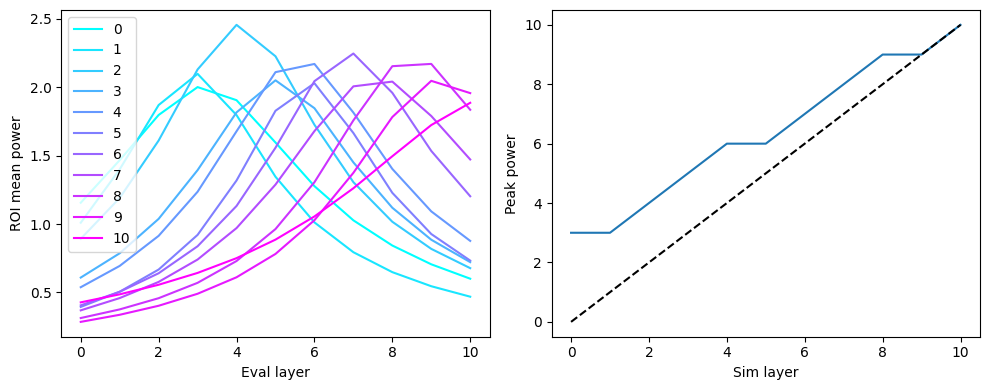

In [12]:
# Average power over trials
mean_layerPow=np.mean(all_layerPow,axis=-1)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the power in each layer model
plt.subplot(1,2,1)
for l in range(n_layers):
    layerPow=mean_layerPow[l,:]
    plt.plot(layerPow, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('ROI mean power')

# For each simulation, find which layer had the greatest power
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerPow=mean_layerPow[l,:]
    pk=np.argmax(layerPow)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak power')
plt.tight_layout()

In [13]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)